In [13]:
import pandas as pd 

train_org = pd.read_csv('train.csv') 
test_org = pd.read_csv('test.csv')

display(train_org.head())
display(test_org.tail())

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차
10962,ACCIDENT_50571,2022-12-31 21,토요일,맑음,대구광역시 동구 효목동,교차로 - 교차로부근,건조,차대차


## **train, test 데이터 기간 확인하기**  

학습(train) 데이터의 기간과 예측 대상이 되는 test 데이터의 기간을 살펴 봅니다

In [14]:
display(f"train : {train_org.iloc[0]['사고일시']} ~ {train_org.iloc[-1]['사고일시']}")
display(f"test : {test_org.iloc[0]['사고일시']} ~ {test_org.iloc[-1]['사고일시']}")     

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

## **예측 대상 확인하기**

sample_submission.csv를 로드하여 출력 형식을 확인해 봄으로서, 
대회 페이지 규칙에 기술되어 있는, 예측 대상이 무엇인지 확인해 봅시다.

최종적으로 예측해야 하는 값은 'ECLO'(인명피해 심각도) 값입니다. 

그러나, train데이터 컬럼에 있는 '사망자수', '중상자수', '경상자수', '부상자수'를 각각 예측하여 ECLO 예측값을 구할 수도 있습니다. 즉, ECLO 값을 예측하는 단일 모델로 접근할 수도,  각각을 별도로 예측하는 모델로 접근할 수도 있습니다. 

<img src="https://drive.google.com/uc?id=19PvSqu8k04D3a-Bskcl-d-Xkckkn2Fvv">  

In [15]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0


## **데이터 전처리**  

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있습니다
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능합니다  

## **파생 변수 생성 1 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [16]:
train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다 
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다 

# 해당 과정을 test_x에 대해서도 반복해줍니다 
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

## **파생 변수 생성 2 : 공간(위치) 정보 생성** 

'시군구' 컬럼으로부터 의미 있는 공산 정보를 추출 및 변환 합니다

In [17]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간', '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

## **파생 변수 추출 3 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [18]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

## **전처리 결과 확인**

지금까지 전처리한 결과를 확인해 봅시다 

In [19]:
display(train_df.head())
display(test_df.head())

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,...,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,...,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,...,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,...,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,...,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안


## **train, test 데이터의 독립변수, 종속 변수 분리**

모델 추론 시점에서 획득할 수 있는 데이터는 학습 시점에서 활용할 수 있는 데이터와 다를 수 있습니다  
그렇기에 본 baseline에서는 test 시점에서만 활용할 수 있는 데이터들(test의 column들)만 사용하여 train 데이터를 구성했습니다 

train_df 중에서 test_x가 가진 column들만 추출하여 train_x(독립변수)를 구성하고, train_df 중에서 예측 목표인 EPDO를 추출하여 train_y(종속변수)를 구성합니다

In [20]:
test_x = test_df.drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

## **범주형(Categorical) 변수, 수치형 변수로 변환하기**

모델 학습을 위해 train_x의 문자열 타입의 컬럼들을 추출하고, LabelEncoder를 활용하여 이 컬럼들을 모두 수치형 변수로 변환해 보겠습니다

In [21]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_x[i]) 
    train_x[i]=le.transform(train_x[i])
    
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    test_x[i]=le.transform(test_x[i])
    
display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,6,2,0,0,2019,1,1,0,0,7,40,2,5
1,6,5,0,0,2019,1,1,0,0,1,4,2,5
2,6,2,0,0,2019,1,1,1,0,6,66,2,5
3,6,2,0,1,2019,1,1,2,0,4,79,2,5
4,6,2,0,1,2019,1,1,4,0,3,129,2,5


,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,5,2,0,0,2022,1,1,1,0,6,99,0,3
1,5,2,0,0,2022,1,1,1,0,6,168,2,5
2,5,2,0,1,2022,1,1,4,0,6,117,0,3
3,5,2,0,1,2022,1,1,4,0,6,126,2,5
4,5,2,0,1,2022,1,1,6,0,1,4,0,3


## **Model Train & Prediction** 

전체 학습 데이터에 대하여 학습후 최종 예측을 합니다. 여기서는 DecisionTreeRegressor 모델로 학습하고 예측하는 예시 코드입니다.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 학습 데이터를 학습 데이터와 검증 데이터로 나눕니다.
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# 모델을 학습합니다.
model = DecisionTreeRegressor()
model.fit(train_x, train_y)

# 검증 데이터에 대한 예측을 수행합니다.
valid_pred = model.predict(valid_x)

# 평균 제곱 오차와 R^2 점수를 계산합니다.
mse = mean_squared_error(valid_y, valid_pred)
print("Mean Squared Error on Validation Data: ", mse)
r2 = r2_score(valid_y, valid_pred)
print("R^2 Score on Validation Data: ", r2)

# 테스트 데이터에 대한 예측을 수행합니다.
test_pred = model.predict(test_x)
print("Test Predictions: ", test_pred)


Mean Squared Error on Validation Data:  20.612029790456955
R^2 Score on Validation Data:  -1.0717459758222398
Test Predictions:  [ 3.  3. 18. ...  9. 23. 12.]


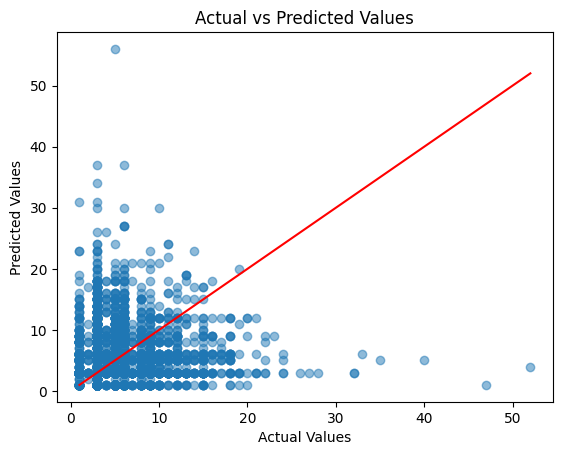

In [27]:
import matplotlib.pyplot as plt

# 검증 데이터에 대한 실제 값과 예측 값을 산점도로 그립니다.
plt.scatter(valid_y, valid_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

# y=x 선을 그립니다. 이 선은 실제 값과 예측 값이 완벽하게 일치할 때의 상황을 나타냅니다.
plt.plot([min(valid_y), max(valid_y)], [min(valid_y), max(valid_y)], color='red')

plt.show()


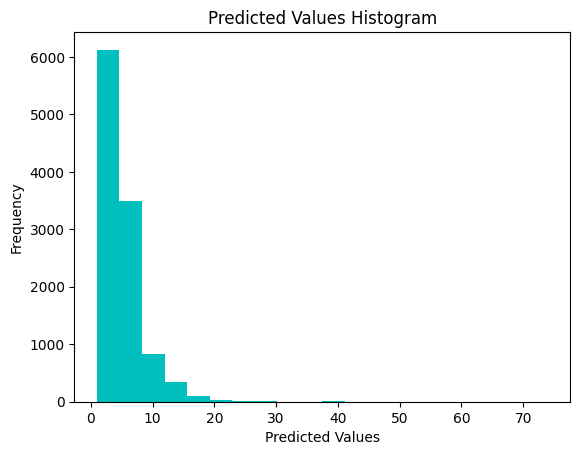

In [28]:
plt.hist(test_pred, bins=20, color='c')
plt.title("Predicted Values Histogram")
plt.xlabel("Predicted Values")
plt.ylabel("Frequency")
plt.show()
